In [ ]:
!pip install transformers
!pip install torch

In [109]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression #le modèle que l'on va utiliser
from sklearn.model_selection import train_test_split
import torch
import transformers as transf
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [110]:
#Données

df = pd.read_csv("data_total_allociné.csv",delimiter=",")
df.rename(columns={'Unnamed: 0': 'commentaire','0': 'note'}, inplace=True)

In [111]:
df.head()

,commentaire,note
0,film très lent plutôt hermétique est une oeuv...,2.0
1,faut voir genre film pour croire ils existent...,3.0
2,des acteurs français jouant les américains ba...,0.5
3,livre boris vian tourné film dans les années ...,5.0
4,irai cracher est sans doute œuvre française p...,1.0


In [112]:
len(df)

49025

In [113]:
print(df.columns)

Index(['commentaire', 'note'], dtype='object')


In [114]:
df.note.value_counts()

,count
note,
5.0,17122
4.0,6909
0.5,5694
4.5,4757
2.5,3112
1.0,3076
3.0,2783
3.5,2570
2.0,2020


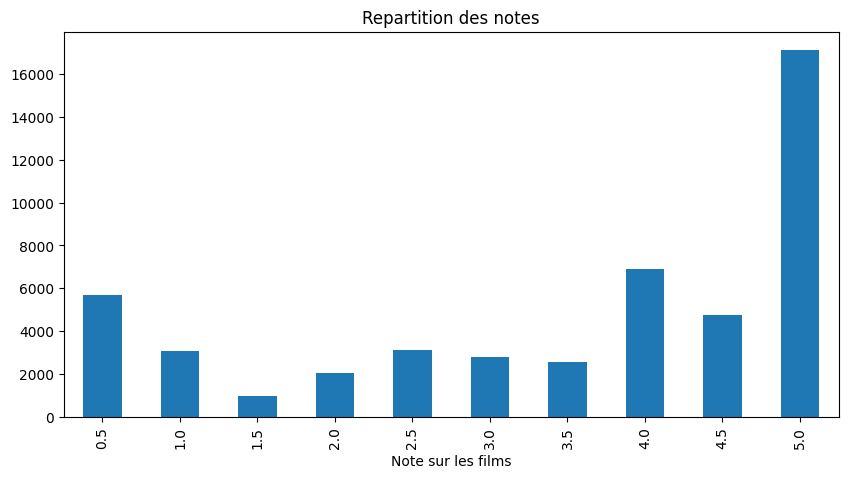

In [115]:
#Graphique montrant la répartition totale des notes

ax = df['note'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Repartition des notes',
          figsize=(10, 5))
ax.set_xlabel("Note sur les films")
plt.show()

In [116]:
df_sample=df.sample(500)

In [117]:
#on verifie on veut que ce soit équilibré
df_sample.note.value_counts()

,count
note,
5.0,178
4.0,60
4.5,60
0.5,53
2.5,38
3.0,32
3.5,24
1.0,23
2.0,19


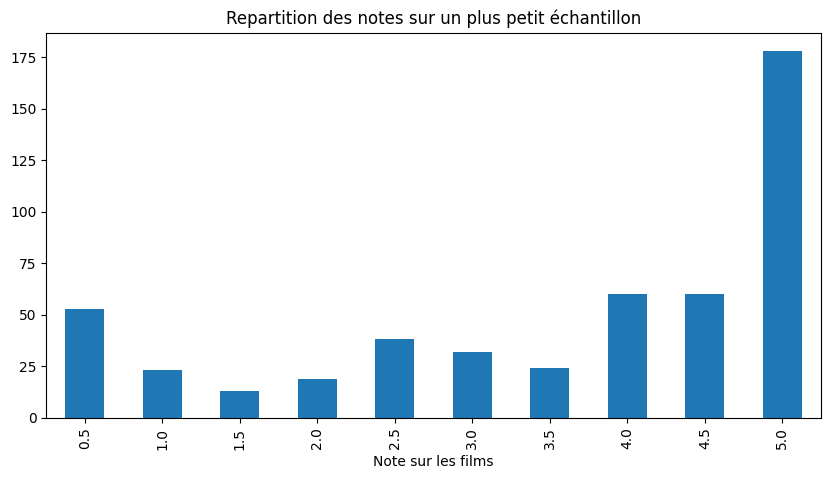

In [118]:
#Graphique qui montre la repartition des notes de l'echantillon (sample)

ax = df_sample['note'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Repartition des notes sur un plus petit échantillon',
          figsize=(10, 5))
ax.set_xlabel("Note sur les films")
plt.show()

### 1- Charger le modèle de Bert

In [119]:
model_class, tokenizer_c, weights_pretrained = (transf.DistilBertModel, transf.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_c.from_pretrained(weights_pretrained)
model = model_class.from_pretrained(weights_pretrained)

### 2- Préparer le texte

In [120]:
exemple = df_sample.commentaire.head(5).values[3]
exemple

' film qui sort lot qui est très différents des autres malgré gros sentiment disney perso m plu '

In [121]:
print(tokenizer.encode(exemple,add_special_tokens=True))

[101, 2143, 21864, 4066, 2843, 21864, 9765, 24403, 2367, 2015, 4078, 8740, 19168, 15451, 17603, 24665, 2891, 15792, 6373, 2566, 6499, 1049, 20228, 2226, 102]


In [122]:
tokenizer.tokenize("a moving, if uneven, success")

['a', 'moving', ',', 'if', 'uneven', ',', 'success']

In [123]:
tokenized = df_sample['commentaire'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True))

In [124]:
tokenized

,commentaire
9811,"[101, 2143, 9765, 23848, 3490, 8873, 4226, 976..."
28418,"[101, 25933, 2015, 18201, 2015, 2139, 14454, 2..."
13642,"[101, 4621, 3672, 25636, 2063, 10861, 2000, 49..."
3931,"[101, 2143, 21864, 4066, 2843, 21864, 9765, 24..."
9444,"[101, 11968, 22825, 2099, 1050, 1037, 15544, 2..."
...,...
29922,"[101, 4848, 13642, 2278, 17935, 3597, 6279, 20..."
39800,"[101, 11967, 6970, 7971, 4630, 2482, 6846, 261..."
16866,"[101, 12753, 4649, 3937, 12753, 4649, 4223, 20..."
8175,"[101, 2128, 21163, 25223, 7367, 19661, 26523, ..."


In [125]:
#pour voir la longueur max
max_len=0
for i in tokenized.values:
  if len(i)>max_len:
    max_len=len(i)

print(max_len)

128


In [126]:
tokenized_zeroes = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(tokenized_zeroes).shape

(500, 128)

In [127]:
attention_mask = np.where(tokenized_zeroes != 0, 1, 0)
attention_mask.shape

(500, 128)

In [128]:
inputs_ids=torch.tensor(tokenized_zeroes)
attention_mask=torch.tensor(attention_mask)

In [129]:
inputs_ids

tensor([[  101,  2143,  9765,  ...,     0,     0,     0],
        [  101, 25933,  2015,  ...,     0,     0,     0],
        [  101,  4621,  3672,  ...,     0,     0,     0],
        ...,
        [  101, 12753,  4649,  ...,     0,     0,     0],
        [  101,  2128, 21163,  ...,     0,     0,     0],
        [  101,  9932,  2063,  ...,  3446,  2099,   102]])

In [130]:
with torch.no_grad():
  last_hidden_states = model(inputs_ids, attention_mask=attention_mask) #on recupere tout

In [131]:
features = last_hidden_states[0][:,0,:] #on filtre le dernier
features.shape

torch.Size([500, 768])

In [132]:
labels = df_sample["note"]
if features.shape[0] != labels.shape[0]:
    features = features.repeat(labels.shape[0], 1)
print(labels)

9811     5.0
28418    0.5
13642    4.0
3931     4.0
9444     5.0
        ... 
29922    3.0
39800    2.5
16866    1.5
8175     4.5
34817    5.0
Name: note, Length: 500, dtype: float64


### 3- Model : Train/Test

In [133]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [134]:
print(train_labels[:10])
print(train_labels.dtype)

17645    1.0
22092    5.0
7555     3.0
7473     5.0
39527    5.0
21069    5.0
44591    4.0
1742     2.0
25241    4.0
35316    5.0
Name: note, dtype: float64
float64


In [135]:
#on doit les transformer en int :
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

on teste un premier modèle avec RandomForest

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200, 300],'max_depth': [5, 10, 20, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],'bootstrap': [True, False]
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search_rf.fit(train_features, train_labels)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search_rf.best_params_)

rf_clf = grid_search_rf.best_estimator_

rf_clf.fit(train_features, train_labels)

test_score = rf_clf.score(test_features, test_labels)
print("Score sur les données de test :", test_score)


Fitting 3 folds for each of 288 candidates, totalling 864 fits
Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Score sur les données de test : 0.328


In [160]:
#Prediction
text = tokenizer.encode("it's a good product, but i don't like it", add_special_tokens=True)
tokenized_zeroes = np.array([text + [0]*(max_len-len(text))])
inputs_ids = torch.tensor(tokenized_zeroes)
attention_mask = torch.tensor(np.where(tokenized_zeroes != 0, 1, 0))

with torch.no_grad():
  pred_hidden_states = model(inputs_ids, attention_mask=attention_mask)
features = pred_hidden_states[0][:,0,:]

In [161]:
rf_clf.predict(features)

array([5])

In [162]:
rf_clf.predict_proba(features)

array([[0.1       , 0.075     , 0.06166667, 0.195     , 0.23666667,
        0.33166667]])

On teste un deuxième modele


In [151]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'weights': ['uniform', 'distance'],  # Pondération des voisins
    'metric': ['euclidean', 'manhattan']  # Distance utilisée
}

# Création du modèle
knn_clf = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid_knn,
                               cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search_knn.fit(train_features, train_labels)


print("Meilleurs hyperparamètres (KNN) :", grid_search_knn.best_params_)

knn_clf = grid_search_knn.best_estimator_

knn_clf.fit(train_features, train_labels)


test_score_knn = knn_clf.score(test_features, test_labels)
print("Score sur les données de test :", test_score_knn)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs hyperparamètres (KNN) : {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Score sur les données de test : 0.288


In [152]:
text = tokenizer.encode("it's a good product, but i don't like it", add_special_tokens=True)
tokenized_zeroes = np.array([text + [0]*(max_len-len(text))])
inputs_ids = torch.tensor(tokenized_zeroes)
attention_mask = torch.tensor(np.where(tokenized_zeroes != 0, 1, 0))

with torch.no_grad():
  pred_hidden_states = model(inputs_ids, attention_mask=attention_mask)
features = pred_hidden_states[0][:,0,:]

In [153]:
knn_clf.predict(features)

array([5])

In [154]:
knn_clf.predict_proba(features)

array([[0.1, 0.2, 0. , 0.1, 0.1, 0.5]])

On teste un troisieme model

In [155]:
from sklearn.svm import SVC

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Création du modèle
svm_clf = SVC(random_state=42)
grid_search_svm = GridSearchCV(estimator=svm_clf, param_grid=param_grid_svm,
                               cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search_svm.fit(train_features, train_labels)

print("Meilleurs hyperparamètres (SVM) :", grid_search_svm.best_params_)

svm_clf = grid_search_svm.best_estimator_

svm_clf.fit(train_features, train_labels)

test_score_svm = svm_clf.score(test_features, test_labels)
print("Score sur les données de test :", test_score_svm)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs hyperparamètres (SVM) : {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Score sur les données de test : 0.328


In [156]:
text = tokenizer.encode("it's a good product, but i don't like it", add_special_tokens=True)
tokenized_zeroes = np.array([text + [0]*(max_len-len(text))])
inputs_ids = torch.tensor(tokenized_zeroes)
attention_mask = torch.tensor(np.where(tokenized_zeroes != 0, 1, 0))

with torch.no_grad():
  pred_hidden_states = model(inputs_ids, attention_mask=attention_mask)
features = pred_hidden_states[0][:,0,:]

In [157]:
svm_clf.predict(features)

array([5])

In [158]:
svm_clf.predict_proba(features)

AttributeError: This 'SVC' has no attribute 'predict_proba'

Pour conclure,

Le meilleur modèle est le RandomForestClassifer avec un score de 0.38. Neanmoins, on s'est rendu que ce résultat était faible probablement à cause de la taille de notre échantillon, même s'il est équilibré. De plus, comme notre base de données est multiclasse, cela a pu aussi fausser les résultats.

En conclusion, la méthode Bert donne des résultats plus performants que la méthode par Batch (qui nous donnait des résultats très faible).